<div style="text-align: center;">
    <h1><strong>UNIVERSIDAD POLITÉCNICA DE CARTAGENA</strong></h1>
    <h2><strong>GRADO EN CIENCIA E INGENIERÍA DE DATOS</strong></h2>

<div style="display:flex; justify-content:center; align-items:center; padding:5px;">
        <img src="imgs/upct_logo.png" style="height:300px; width:auto">
    </div>

<h2><strong>Procesamiento del Lenguaje Natural</strong></h2>

<h3><strong>PROYECTO:</strong><br>
    <strong>Aplicación PLN para análisis y procesamiento de texto de carácter geopolítico, económico-bursátil y político.</strong></h3>

<p><strong>ESTUDIANTES</strong></p>
    <ul style="list-style-type:none; padding: 0;">
        <li>Rubén Gil Martínez</li>
        <li>Guillermo López Pérez</li>
    </ul>
</div>


**LIBRERÍAS**

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import csv
import datetime as dt
import time

import praw
import pandas as pd
from datetime import datetime
import time
import re
import os


import nltk

# 1) Compilación del corpus de comentarios de Reddit a través de su API y uso de Procesamiento Léxico:

In [3]:
# Configuración de credenciales
reddit = praw.Reddit(
    client_id='v4Ozy7so3ZR5n-i4r7Spqw',
    client_secret='iDAtL0KxYY9ky4GyPWyUM2OAZ4LnBg',
    user_agent='dl-pln-2025-RGM-GLP'
)

In [4]:
# Prueba simple de correcta autenticación
try:
    # Intenta acceder a tu nombre de usuario para verificar autenticación
    print(f"Autenticado como: {reddit.user.me()}")
    
    # Prueba una solicitud simple
    for submission in reddit.subreddit("test").hot(limit=1):
        print(f"Título del post de prueba: {submission.title}")
        
    print("¡Autenticación exitosa!")
    
except Exception as e:
    print(f"Error de autenticación: {type(e).__name__} - {str(e)}")
    print("Por favor, verifica tus credenciales y la configuración de la aplicación.")

Autenticado como: None
Título del post de prueba: Some test commands
¡Autenticación exitosa!


In [ ]:
# Lista de subreddits a extraer
subreddits = ['Economics', 'finance', 'StockMarket', 'geopolitics', 'worldnews', 'business']

# Expresiones regulares para filtrado
url_pattern = re.compile(r'(https?://\S+)')
email_pattern = re.compile(r'[\w\.-]+@[\w\.-]+')

# Función para verificar si un comentario es válido
def is_valid_comment(text):
    if len(text) < 30:  # Mínimo de 30 caracteres
        return False
    
    # Eliminar URLs y emails
    text_cleaned = url_pattern.sub(' ', text)
    text_cleaned = email_pattern.sub(' ', text_cleaned)
    
    # Verificar si queda suficiente contenido
    return len(text_cleaned.strip()) >= 30

**EXTRACCIÓN DEL CORPUS DE COMENTARIOS EN ARCHIVOS JSON INDIVIDUALES PARA CADA SUBREDDIT**

- 6 subreddits distintos
- 20 hilos distintos de cada subreddit
- Alrededor de 50 comentarios por cada hilo

Durante la extracción hemos tenido en cuenta el evitar duplicados, tomar comentarios distribuidos en el tiempo (hemos tomado desde comentarios de la última semana hasta comentarios de otros años), tomar comentarios que no sean muy cortos y que además no contengan ni urls ni gmails ya que estos no aportan información relevante. 

Parte de este filtrado de comentarios ha sido posible gracias a la función is_valid_comment() previamente definida.

In [ ]:
# Procesamiento de cada subreddit
for subreddit_name in subreddits:
    print(f"Procesando subreddit: {subreddit_name}...")
    
    subreddit_data = {
        "subreddit_name": subreddit_name,
        "threads": []
    }

    subreddit = reddit.subreddit(subreddit_name)
    threads_collected = 0  # Contador de hilos extraídos
    extracted_thread_ids = set()  # Para evitar duplicados

    # Diferentes filtros de tiempo
    time_filters = ['all', 'week', 'month', 'year']

    for time_filter in time_filters:
        if threads_collected >= 20:
            break
        
        print(f"  Extrayendo de {subreddit_name} con filtro: {time_filter}")

        try:
            threads = list(subreddit.top(time_filter=time_filter, limit=8))  # Procesamos 8 hilos para cada temporalidad para mayor rapidez y evitar bloqueos
            
            for thread in threads:
                if threads_collected >= 20 or thread.id in extracted_thread_ids:  # Evitar duplicados
                    continue  

                print(f"    Procesando hilo: {thread.title}")

                # Información del hilo
                thread_info = {
                    "thread_id": thread.id,
                    "title": thread.title,
                    "author": str(thread.author),
                    "created_utc": datetime.utcfromtimestamp(thread.created_utc).isoformat(),
                    "score": thread.score,
                    "url": thread.url,
                    "permalink": thread.permalink,
                    "time_filter": time_filter,
                    "subreddit_name": subreddit_name,
                    "comments": []
                }


                # Extraer comentarios
                try:
                    thread.comments.replace_more(limit=3)  # Evita cargar demasiados comentarios
                    flat_comments = thread.comments.list()
                except Exception as e:
                    print(f"      Error al cargar comentarios: {e}")
                    continue

                valid_comments_count = 0

                for comment in flat_comments:
                    if valid_comments_count >= 50:
                        break

                    if is_valid_comment(comment.body): # Si el comentario pasa el filtro de validez es almacenado en la lista de comentarios de su respectivo hilo

                        comment_info = {
                            'comment_id': comment.id,
                            'author': str(comment.author),
                            'text': comment.body,
                            'score': comment.score,
                            'created_utc': datetime.utcfromtimestamp(comment.created_utc).isoformat(),
                            'subreddit_name': subreddit_name,
                            'thread_id': thread.id,
                            'is_submitter': comment.is_submitter,
                            'permalink': comment.permalink
                        }

                        thread_info["comments"].append(comment_info)
                        valid_comments_count += 1

                if valid_comments_count >= 25:  # Mínimo de 25 comentarios válidos, sino, el hilo es descartado
                    subreddit_data["threads"].append(thread_info)
                    extracted_thread_ids.add(thread.id)
                    threads_collected += 1
                    print(f"      Añadido con {valid_comments_count} comentarios válidos")
                else:
                    print(f"      Descartado: solo {valid_comments_count} comentarios válidos")

                time.sleep(1.5)  # Evitar exceso de peticiones a Reddit, nos permite cumplir con las normas de uso de la API y evitar bloqueos temporales

        except Exception as e:
            print(f"Error en {subreddit_name} con filtro {time_filter}: {e}")
            continue

    # Guardar en JSON
    os.makedirs('datasets', exist_ok=True)
    output_file = os.path.join('datasets', f"{subreddit_name}_data_2.0.json")

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(subreddit_data, f, ensure_ascii=False, indent=2)

    print(f"Completado: {subreddit_name} - {threads_collected} hilos guardados en {output_file}\n")

print("Extracción completa.")


Procesando subreddit: Economics...
  Extrayendo de Economics con filtro: all
    Procesando hilo: Economist Warns That Elon Musk Is About to Cause a "Deep, Deep Recession"
      Añadido con 50 comentarios válidos
    Procesando hilo: 65% of Americans support monthly $2,000 COVID stimulus payments, new poll shows
      Añadido con 50 comentarios válidos
    Procesando hilo: US tourism to suffer huge '£49 billion drop' under Donald Trump
      Añadido con 50 comentarios válidos
    Procesando hilo: Fed report finds 75% of $800 billion Paycheck Protection Program didn't reach employees
      Añadido con 30 comentarios válidos
    Procesando hilo: Trudeau announces Canada ban on Russian oil imports. “Today, we are announcing a ban on all imports of crude oil from Russia, an industry that has benefited President Putin and his oligarchs greatly,”
      Añadido con 50 comentarios válidos
    Procesando hilo: Trump's first 50 days mark one of the worst starts for the S&P 500 under any presiden

**PROCESAMIENTO LÉXICO Y CREACIÓN DE UN DATAFRAME PARA TRATAR CON MAYOR FACILIDAD LOS COMENTARIOS**

In [1]:
from symspellpy import SymSpell, Verbosity
import spacy

# Cargamos el modelo de spaCy para realizar la Lematización
nlp = spacy.load('en_core_web_sm')

# Configuración de SymSpell para realizar la corrección automática de errores ortográficos
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = "datasets/frequency_dictionary_en_82_765.txt"  
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1, separator=" ")


True

In [5]:
def remove_emojis(text):
    # Patrón para detectar emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # símbolos & pictogramas
        u"\U0001F680-\U0001F6FF"  # símbolos de transporte & mapas
        u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

**FUNCIÓN DE PROCESAMIENTO LÉXICO**

In [6]:
def preprocess_text(text, autocorrect=True):
    # Eliminar emojis
    text = remove_emojis(text)
    
    # Convertimos a minúsculas
    text = text.lower()
    
    # Procesamiento con spaCy
    doc = nlp(text)
    
    # Tokenización y eliminación de signos de puntuación y números
    tokens = [token.text for token in doc if not token.is_punct and not token.like_num]
    
    # Corrección ortográfica con SymSpellPy
    if autocorrect:
        corrected_tokens = []
        for token in tokens:
            suggestions = sym_spell.lookup(token, Verbosity.CLOSEST, max_edit_distance=2)
            # Si hay sugerencias, tomamos la primera
            # Si no, mantenemos el token original
            if suggestions:
                corrected_tokens.append(suggestions[0].term)
            else:
                corrected_tokens.append(token)
        tokens = corrected_tokens
    
    # Eliminación de stopwords
    tokens = [token for token in tokens if not token in nlp.Defaults.stop_words]
    
    # Lematización con spaCy
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

## Procesamiento Léxico con spaCy y SymSpellPy

Usamos **spaCy** para el procesamiento completo del texto. Aprovechamos sus capacidades integradas para:

- Tokenización  
- Detección de números y puntuación  
- Uso de su propia lista de *stopwords*  
- Lematización más precisa  

Además, realizamos la **corrección ortográfica** con **SymSpellPy**.

### Ventajas de usar spaCy

El proceso es más eficiente porque spaCy está optimizado para procesamiento de texto. La lematización con spaCy suele ser más precisa que con NLTK porque:

- Considera el contexto de la palabra  
- Tiene mejor manejo de formas irregulares  
- Está más actualizado con el lenguaje moderno  
- Es más rápido en el procesamiento  




**REALIZACIÓN DEL PROCESAMIENTO Y PREPARACIÓN DE LOS COMENTARIOS PARA SU POSTERIOR USO EN DIVERSAS TAREAS**

In [7]:
# Cargamos los datos extraídos y procesamos los comentarios
all_comments = []
dataset_path = 'datasets'

for filename in os.listdir(dataset_path):
    if filename.endswith('_data_2.0.json'):
        with open(os.path.join(dataset_path, filename), 'r', encoding='utf-8') as file:
            data = json.load(file)
            
            for thread in data['threads']:
                for comment in thread['comments']:
                    comment_data = {
                        'body': comment['text'],
                        'score': comment['score'],
                        'created_utc': comment['created_utc'],
                        'thread_title': thread['title'],
                        'subreddit': data['subreddit_name'],
                        'processed_text': preprocess_text(comment['text'], autocorrect=True),
                        'processed_text_no_correction': preprocess_text(comment['text'], autocorrect=False)
                    }
                    all_comments.append(comment_data)

**CREACIÓN DE UN DATAFRAME CON TODOS LOS COMENTARIOS EXTRAÍDOS**

In [8]:
print(len(all_comments))  # Obtención de alrededor de 6000 comentarios válidos

5891


In [9]:
# Crear DataFrame
df_comments = pd.DataFrame(all_comments)

# Mostrar las primeras filas y información del DataFrame
df_comments.head(10)


,body,score,created_utc,thread_title,subreddit,processed_text,processed_text_no_correction
0,Consumer staples. \n\nChurch and Dwight is mis...,94,2022-12-17T04:52:06,The 11 companies that own everything,business,consumer staple church dwight miss clorox clorox,consumer staple \n\n church dwight miss \n\n ...
1,now show how much their boards overlap to real...,146,2022-12-17T07:41:32,The 11 companies that own everything,business,board overlap trigger nausea,board overlap trigger nausea
2,"""everything"" here is limited to consumable pro...",196,2022-12-17T05:11:13,The 11 companies that own everything,business,limited consumable product fraction overall ec...,limited consumable product fraction overall ec...
3,I work for Mars and this graph only shows thei...,9,2022-12-17T19:39:32,The 11 companies that own everything,business,work mar graph show snack relate holding mar o...,work mar graph show snack relate holding mar o...
4,Missing Blackstone and Apollo asset management 😛,22,2022-12-17T07:41:36,The 11 companies that own everything,business,miss blackstone apollo asset management,miss blackstone apollo asset management
5,"Who owns Dr. Pepper you ask? No one, she’s her...",5,2022-12-17T17:47:49,The 11 companies that own everything,business,own pepper ask woman,owns dr pepper ask woman
6,We won't have a chance at having a representat...,3,2022-12-17T13:04:23,The 11 companies that own everything,business,chance have representative government limit ca...,will chance have representative government lim...
7,Now do this for communication and media please.,3,2022-12-17T15:41:06,The 11 companies that own everything,business,communication medium,communication medium
8,"Um excuse me, I don't know much about business...",3,2022-12-17T09:02:32,The 11 companies that own everything,business,excuse know business lipton pepsi unilever,um excuse know business lipton pepsico uniclever
9,"Mondelez is a bit fluffed up with Cadbury, Cad...",3,2022-12-17T09:08:01,The 11 companies that own everything,business,mondale bit fluff sudbury sudbury dairy milk s...,mondelez bit fluff cadbury cadbury dairy milk ...


# 2) Clasificador de comentarios en Subreddits:

**CREAMOS LOS CONJUNTOS DE ENTRENAMIENTO Y TEST TENEIENDO EN CUENTA LA CORRECTA ESTRATIFICACIÓN DE LOS COMENTARIOS**

Esta estratificación es clave para que en ambas particiones se mantega la distribución de etiquetas para cada subreddit evitando así posibles sesgos.

In [63]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_comments, test_size=0.3, random_state=2025, stratify=df_comments['subreddit'])


In [64]:
df_train.shape, df_test.shape, 

((4123, 7), (1768, 7))

In [65]:
df_train['subreddit'].value_counts() # Muestra de la correcta estratificación de los datos

subreddit
geopolitics    700
StockMarket    700
worldnews      700
Economics      686
business       685
finance        652
Name: count, dtype: int64

**2.1) USO DE REPRESENTACIONES TRADICIONALES + MODELO DE CLASIFICACIÓN SVM**

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from BM25_Trans import BM25Transformer 
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

## Kernel RBF o Polinomial en nuestro clasificador SVM en vez de Lineal

Elegimos este tipo de kernels debido a que:
1. Capturan relaciones no lineales entre palabras y temas
2. Son más potentes que el kernel lineal para este tipo de comentarios 
3. Se adaptan mejor a la naturaleza diversa del lenguaje natural 
4. Ofrecn un mejor rendimiento en la tarea de clasificación de texto

**CREACIÓN DE LOS PIPELINES**

In [ ]:
# Creamos el pipeline de TF con SVC
clasificador_TF = Pipeline([
    ('vect', CountVectorizer()),
    ('tf', TfidfTransformer(use_idf=False)),
    ('clf', SVC(kernel='rbf', random_state=2025, tol=1e-5)),])

# Creamos el pipeline de TFIDF con SVC y lo guardamos en clasificador_TFIDF
clasificador_TFIDF = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel= 'poly', random_state=2025, tol=1e-4, C=2, degree=3)),])

# Creamos el pipeline de BM25 con SVC y lo guardamos en clasificador_BM25
clasificador_BM25 = Pipeline([
    ('vect', CountVectorizer()),
    ('bm25', BM25Transformer(k=1.2, b=0.5)),
    ('clf', SVC(kernel= 'rbf', random_state=2025, tol=1e-5)),])

**ENTRENAMIENTO DE LOS MODELOS**

In [82]:
clasificador_TF.fit(df_train.processed_text, df_train.subreddit)

clasificador_TFIDF.fit(df_train.processed_text, df_train.subreddit)

clasificador_BM25.fit(df_train.processed_text, df_train.subreddit)

Pipeline(steps=[('vect', CountVectorizer()), ('bm25', BM25Transformer(b=0.5)),
                ('clf', SVC(random_state=2025, tol=1e-05))])

**EVALUACIÓN DE LOS MODELOS**
- Reporte de Métricas
- Matriz de Confusión

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [83]:
# Evaluamos el TF
predicted_tf = clasificador_TF.predict(df_test.processed_text)
accuracy_tf = accuracy_score(df_test.subreddit, predicted_tf)

print("Resultados TF ----- Accuracy:", accuracy_tf)
print(classification_report(df_test.subreddit, predicted_tf))
print('=' * 40)


# Evaluamos el TF-IDF
predicted_tfidf = clasificador_TFIDF.predict(df_test.processed_text)
accuracy_tfidf = accuracy_score(df_test.subreddit, predicted_tfidf)

print("Resultados TF-IDF ----- Accuracy:", accuracy_tfidf)
print(classification_report(df_test.subreddit, predicted_tfidf))
print('=' * 40)


# Evaluamos el BM25
predicted_bm25 = clasificador_BM25.predict(df_test.processed_text)
accuracy_bm25 = accuracy_score(df_test.subreddit, predicted_bm25)

print("Resultados BM25 ----- Accuracy:", accuracy_bm25)
print(classification_report(df_test.subreddit, predicted_bm25))

Resultados TF ----- Accuracy: 0.48755656108597284
              precision    recall  f1-score   support

   Economics       0.54      0.48      0.51       294
 StockMarket       0.39      0.38      0.39       300
    business       0.41      0.46      0.43       294
     finance       0.50      0.42      0.46       280
 geopolitics       0.62      0.57      0.59       300
   worldnews       0.49      0.62      0.55       300

    accuracy                           0.49      1768
   macro avg       0.49      0.49      0.49      1768
weighted avg       0.49      0.49      0.49      1768

Resultados TF-IDF ----- Accuracy: 0.541289592760181
              precision    recall  f1-score   support

   Economics       0.57      0.50      0.53       294
 StockMarket       0.45      0.47      0.46       300
    business       0.45      0.49      0.47       294
     finance       0.59      0.50      0.54       280
 geopolitics       0.64      0.67      0.65       300
   worldnews       0.57      0

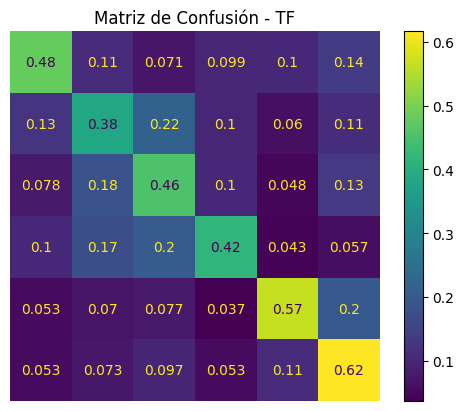

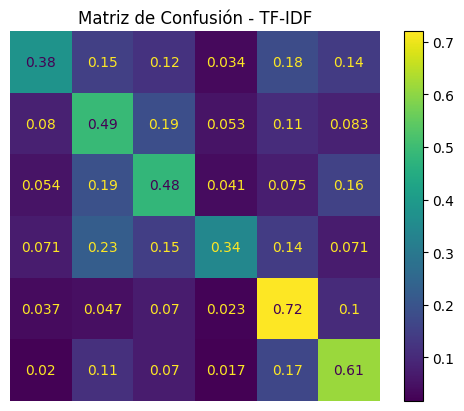

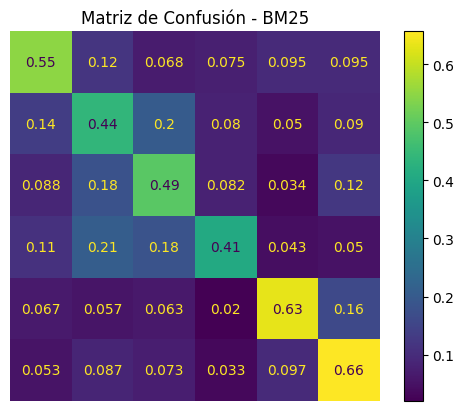

In [ ]:
import matplotlib.pyplot as plt

# Matriz de confusión para TF

ConfusionMatrixDisplay.from_predictions(
    df_test.subreddit, 
    predicted_tf,
     normalize='true',
    xticks_rotation=45
)
plt.title('Matriz de Confusión - TF')
plt.axis('off')
plt.show()

# Matriz de confusión para TF-IDF
ConfusionMatrixDisplay.from_predictions(
    df_test.subreddit, 
    predicted_tfidf,
     normalize='true',
    xticks_rotation=45

)
plt.title('Matriz de Confusión - TF-IDF')
plt.axis('off')
plt.show()


# Matriz de confusión para BM25
ConfusionMatrixDisplay.from_predictions(
    df_test.subreddit, 
    predicted_bm25,
     normalize='true',
    xticks_rotation=45
)
plt.title('Matriz de Confusión - BM25')
plt.axis('off')
plt.show()



Viendo que hay posibles mejoras en el rendimiento de los modelos decidimos realizar una búsqueda de hiperparámetros óptimos mediante **GridSearchCV**

In [80]:
from sklearn.model_selection import GridSearchCV

# Definimos los parámetros a probar para cada componente
param_grid = {
    # Parámetros para BM25
    'bm25__k': [0.8, 1.2],
    'bm25__b': [0.5],
    
    # Parámetros para SVM
    'clf__C': [1, 1.5, 2, 3, 5],
    'clf__kernel': ['rbf', 'poly'],
    'clf__degree': [2, 3, 4],
    'clf__tol': [1e-4, 1e-5]
}

# Creamos el pipeline base para BM25 + SVM
pipeline_BM25 = Pipeline([
    ('vect', CountVectorizer()),
    ('bm25', BM25Transformer()),
    ('clf', SVC(random_state=2025))
])

# Creamos el GridSearchCV
grid_search = GridSearchCV(
    pipeline_BM25,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Entrenamos el modelo con GridSearch
grid_search.fit(df_train.processed_text, df_train.subreddit)

# Mostramos los mejores parámetros y el mejor score
print("Mejores parámetros:", grid_search.best_params_)
print("\nMejor score:", grid_search.best_score_)

# Evaluamos el mejor modelo en el conjunto de test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(df_test.processed_text)

print("\nResultados en el conjunto de test:")
print("Accuracy:", accuracy_score(df_test.subreddit, y_pred))
print("\nReporte de clasificación:")
print(classification_report(df_test.subreddit, y_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Mejores parámetros: {'bm25__b': 0.5, 'bm25__k': 1.2, 'clf__C': 1, 'clf__degree': 2, 'clf__kernel': 'poly', 'clf__tol': 0.0001}

Mejor score: 0.52267519858782

Resultados en el conjunto de test:
Accuracy: 0.5514705882352942

Reporte de clasificación:
              precision    recall  f1-score   support

   Economics       0.57      0.54      0.55       294
 StockMarket       0.45      0.48      0.46       300
    business       0.48      0.49      0.49       294
     finance       0.62      0.47      0.53       280
 geopolitics       0.63      0.69      0.66       300
   worldnews       0.57      0.63      0.60       300

    accuracy                           0.55      1768
   macro avg       0.55      0.55      0.55      1768
weighted avg       0.55      0.55      0.55      1768



**MATRIZ DE CONFUSIÓN DEL MEJOR MODELO CONSTRUIDO**

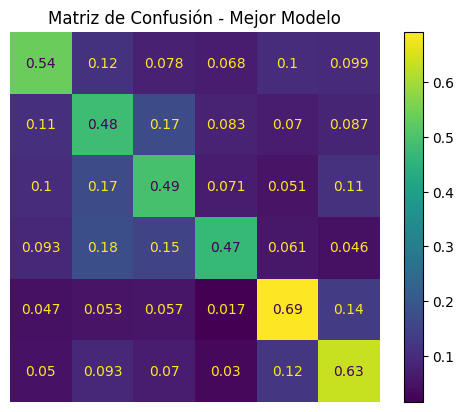

In [87]:
ConfusionMatrixDisplay.from_predictions(
    df_test.subreddit, 
    best_model.predict(df_test.processed_text),
     normalize='true',
    xticks_rotation=45
)
plt.title('Matriz de Confusión - Mejor Modelo')
plt.axis('off')
plt.show()